Student ID: A0258345X

Link to GitHub Repository: [https://github.com/chenyupcy/DSA4262-Assignment-2]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV


In [2]:
train_df = pd.read_csv("dreaddit datasets/dreaddit-train.csv")
test_df = pd.read_csv("dreaddit datasets/dreaddit-test.csv")

print(train_df.shape, test_df.shape)

(2838, 116) (715, 116)


In [3]:
# check class balance
label_counts = train_df["label"].value_counts()

print(label_counts)
print("proportion:", label_counts[1] / label_counts.sum())


label
1    1488
0    1350
Name: count, dtype: int64
proportion: 0.5243128964059197


# Data Visualisation

## Subreddit Distribution

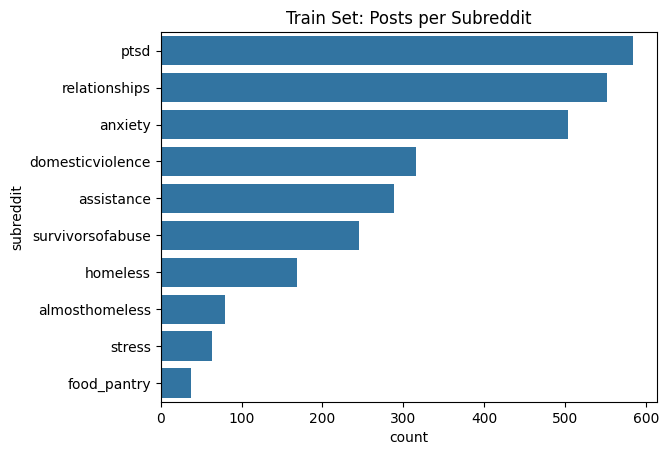

In [4]:
sns.countplot(
    data=train_df,
    y="subreddit",
    order=train_df["subreddit"].value_counts().index
)
plt.title("Train Set: Posts per Subreddit")
plt.show()


The subreddit distribution plot shows the distribution of training samples across different subreddits with more posts coming from pstd, relationships and anxiety subreddits and fewer posts coming from almosthomeless, stress and food_pantry. Given the imbalance in the distribution, it could be the case where the model perform better for subreddits with more posts than those with fewer posts simply due to more training data seen. 

## Stress Rate by Subreddit

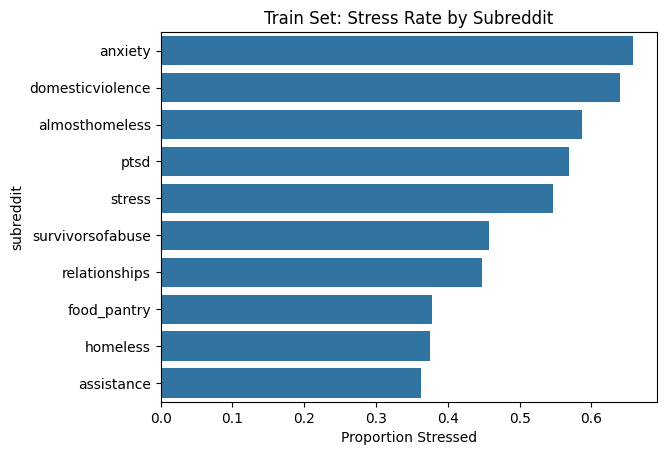

subreddit
anxiety             0.658052
domesticviolence    0.639241
almosthomeless      0.587500
ptsd                0.568493
stress              0.546875
survivorsofabuse    0.457143
relationships       0.447464
food_pantry         0.378378
homeless            0.375000
assistance          0.363322
Name: label, dtype: float64

In [5]:
stress_rate = (
    train_df
    .groupby("subreddit")["label"]
    .mean()
    .sort_values(ascending=False)
)

sns.barplot(x=stress_rate.values, y=stress_rate.index)
plt.title("Train Set: Stress Rate by Subreddit")
plt.xlabel("Proportion Stressed")
plt.show()

display(stress_rate)


Stress rate varies quite significantly across different subreddits communities, suggesting that stress could be partly community-driven. Forums centered on anxiety and domestic violence, show substantially higher stress rates of more than 60%, while resource-oriented communities such as food_pantry and assistance subreddits show lower stress rates or the posts may contain indirect language.

## Distribution of Sentiment Value

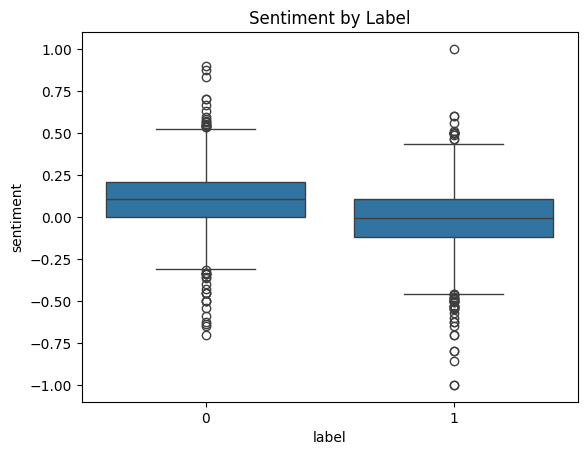

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,1350.0,0.103359,0.180322,-0.7,0.000000,0.107170,0.210125,0.9
1,1488.0,-0.016071,0.191373,-1.0,-0.120982,-0.008075,0.103957,1.0


In [6]:
sns.boxplot(x="label", y="sentiment", data=train_df)
plt.title("Sentiment by Label")
plt.show()

train_df.groupby("label")["sentiment"].describe()


On average, stressed posts exhibit slightly more negative sentiment, however the distribution between stressed and non-stressed posts overlap substantially. This mean that stress is not necessarily equivalent to negative sentiment. It could mean that some stressed posts might contain cognitive stress rather than direct emotional expression of stress. Therefore, sentiment alone is not sufficient in detecting stress.

## Preview of Lexical Signals Using TF-IDF

In [7]:

vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
X_tfidf = vectorizer.fit_transform(train_df["text"].fillna(""))

feature_names = np.array(vectorizer.get_feature_names_out())
stress_mask = (train_df["label"] == 1).to_numpy()  

mean_stress = X_tfidf[stress_mask].mean(axis=0).A1
mean_non    = X_tfidf[~stress_mask].mean(axis=0).A1

diff = mean_stress - mean_non
top_idx = np.argsort(diff)[-80:][::-1]

print("Top stress-associated words:")
print(feature_names[top_idx])


Top stress-associated words:
['feel' 'don' 'just' 'anxiety' 'like' 'know' 've' 'feeling' 'scared' 'bad'
 'hate' 'stop' 'anxious' 'fucking' 'getting' 'panic' 'happened' 'tell'
 'hard' 'want' 'dr' 'afraid' 'days' 'past' 'sick' 'job' 'need' 'tl'
 'right' 'attacks' 'worse' 'tired' 'anymore' 'makes' 'going' 'day'
 'trying' 'sorry' 'leave' 'feels' 'crying' 'work' 'thinking' 'worried'
 'life' 'shit' 'school' 'boyfriend' 'attack' 'im' 'fear' 'having' 'pain'
 'angry' 'constantly' 'horrible' 'really' 'felt' 'literally' 'won'
 'terrified' 'depressed' 'car' 'losing' 'terrible' 'deal' 'stress' 'awful'
 'heart' 'depression' 'stupid' 'head' 'home' 'memories' 'worst' 'honestly'
 'triggered' 'fuck' 'sad' 'end']


**Purpose**: Before modelling, a lexical comparison using TF-IDF is used to identify some of the words that appear more strongly in stressed posts compared to non-stressed posts. The aim is to see how does stress "look" like in vocabulary or language and whether certain words themselves already signal obvious signs of stress. This is because if simple but meaningful stress-related words are very explicit about stress, simple models such as using TF-IDF and lexical modelling may still work. 

**Method**: The text is first converted into TF-IDF vectors, then average TF-IDF weight per word in stressed and non-stressd posts are computed to find the difference between these 2 groups. The words are ranked by the difference.

**Observations**:

1. For the stress posts, there are some words that are clear emotional distress markers that exhibit very explicit emotions such as "anxiety", "attacks", "scared", "afraid", "bad". In addition, some words connotes physiological symptoms such as "sleep", "tired" which aligns with psychological symptoms of stress as a response to high work demands.

2. Another trend is that some words are more situational rather than directly expressing stress using emotional descriptors such as "school", "job", "lately", "boyfriend". These words could be descriptors of the situation itself that implies stress such as job related or relationship related problems resulting in a stressed situation. 

**Limitation**: A limitation is that some words are in short form, making it hard to interpret the actual word without context or without reading the whole text.

# Data Preparation

In [8]:
liwc_cols = [c for c in train_df.columns if c.startswith("lex_liwc")]

# for psychological patterns
len(liwc_cols)
liwc_cols[:10]

y_col = "label"
subreddit_col = "subreddit"
text_col  = "text"


# Feature Engineering and Model Architecture

To balance predictive performance and interpretability, the model chosen uses a combination of TF-IDF lexical features, pre-computed LIWC psychological features provided in the dataset, and a Logistic Regression classifier. This allows the model to examine which linguistic signals are most strongly associated with stress while maintaining interpretability in model behaviour.

Rationale:

- TF-IDF is useful for stress detection because stress is often expressed through specific words and phrases such as emotional terms, or negative terms. It assigns higher weights to words that are distinctive and informative and using n-grams (bi-grams) allows the model to capture phrases with meaning. 

- LIWC complements TF-IDF by providing psychologically grounded features rather than relying solely on individual words and phrases.

- Since TF-IDF produces many features, logistic regression classifier can perform well in high-dimensional settings and handles sparse input efficiently. It is also more interpretable as each feature has an associated coefficient to represent how strongly it contributes to predicting stress. 

## Feature Engineering

In [9]:
# text feature engineering
text_transformer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 3),
    stop_words="english",
    min_df=2,
    max_df=0.85,
    sublinear_tf=True,
    norm="l2"
)
# combine LIWC + sentiment
psych_cols = liwc_cols + ["sentiment"]

# combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, text_col),
        ("psych", StandardScaler(), psych_cols)
    ]
)

For the text column, TF-IDF was applied to raw text to capture important words and phrases related to stress, including both unigrams, bigrams and trigrams. Common stop words were removed, and to reduce noise, words that appear less often (in less than 2 posts) were excluded. 

LIWC features and the "sentiment" feature were standardised using feature scaling to ensure comparability across features. 


## Model Training

In [10]:
model = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    solver="liblinear"
)
clf = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", model)
])

X_train = train_df.drop(columns=[y_col])
y_train = train_df[y_col]
X_test = test_df
y_test = test_df[y_col]

In [11]:
# cross-validation with stratified k-fold
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

cv_scores = cross_val_score(
    clf,
    X_train,
    y_train,
    cv=cv,
    scoring="f1"
)

print("CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

CV F1 scores: [0.79153094 0.76320273 0.79731993 0.77133106 0.78172589]
Mean CV F1: 0.7810221099386208


To evaluate model robustness, a 5-fold stratified cross-validation using F1-score is applied. This would provide a more reliable estimate of the performance compared to a single train-test split model. 

In [12]:
# Hyperparameter tuning for logistic regression C parameter
param_grid = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 5, 10, 20],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"]
}

grid = GridSearchCV(
    clf,
    param_grid,
    cv=cv,             
    scoring="f1",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Best CV F1:", grid.best_score_)
print("Best params:", grid.best_params_)

clf = grid.best_estimator_
clf.fit(X_train, y_train)

c:\Users\celes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Best CV F1: 0.7811269717933089
Best params: {'classifier__C': 5, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


c:\Users\celes\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('text', ...), ('psych', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transform

To optimise model performance, hyperparameter tuning using GridSearchCV is done to select the optimal regularisation strength (C) for the logistic regression classifier. This hyperparameter C controls the strength of regularisation which is important since high dimensional feature space due to TF-IDF are prone to overfitting.

## Model Evaluation

In [13]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       346
           1       0.75      0.77      0.76       369

    accuracy                           0.75       715
   macro avg       0.75      0.75      0.75       715
weighted avg       0.75      0.75      0.75       715

[[251  95]
 [ 86 283]]


The result shows that when the model predicts whether a post is stressed, it is 75% accurate. The recall is 77% which is significant. The F1-score is 0.76, which indicates that the model is relatively effective at detecting stress while maintaining reasonable precision and recall. However, the remaining 0.24 lack in F1 score could suggest that some texts contain ambiguity, likely due to indirect expressions, sarcasm, or complexity due to the context that the model cannot fully capture. 

## Model Interpretation (Features That Contribute Most to The Prediction)

In [14]:
feature_names = (
    clf.named_steps["preprocess"]
    .named_transformers_["text"]
    .get_feature_names_out()
)

liwc_feature_names = liwc_cols + ["sentiment"]
all_features = np.concatenate([feature_names, liwc_feature_names])
coefficients = clf.named_steps["classifier"].coef_[0]

feature_importance = pd.DataFrame({
    "feature": all_features,
    "coef": coefficients
}).sort_values(by="coef", ascending=False)

feature_importance.head(30)


,feature,coef
1795,calm,2.964963
13016,tell,2.748509
7907,literally,2.528847
9012,need,2.472296
3571,don know,2.461093
11228,right,2.407573
9143,news,2.307196
6242,honestly,2.250502
153,30,2.245215
2928,days,2.185046


The coefficients of the logistic regression are extracted which indicates how each feature (word) influences the model's prediction. Each feature has a learned weight associated with it and the most positive coefficients correspond to features that increase the predicted probability of stress.
Some common indicators that have strong links to stress include:

1. Help- seeking terms:
    - words like "tell", "need", "trying"
    - suggests the text might involve describing struggles and seeking advice or support on ways to cope
2. Uncertainty related terms:
    - words like "don know", "unable"
    - suggests the text might connote difficulties or inability to do something
3. Terms on aspects of life:
    - words like "money", "job", "car", "situation", "issues", "baby"
    - suggests adversities coming from financial or situational challenges.
4. Emphasis markers:
    - words like "absolutely", "honestly", "literally", "terried"
    - suggests some emphasis on the intensity of their emotions, attempting to amplify their expression to emphasise the gravity of the issues.
5. Temporal terms:
    - words like "days", "past", 
    - suggest potentially ongoing or prolonged state of stress

6. Others:
    - the term "tl", "tl dr" seem to be strongly associated with stressed posts. Although they are not explicitly or indirectly related to stress, they could appear in longer posts or posts seeking advice given a contextual situation.


In [15]:
top_negative = feature_importance.sort_values(
    by="coef",
    ascending=True
).head(30)

top_negative

,feature,coef
4724,finally,-2.867863
1137,avoid,-2.740365
15268,years,-2.587991
594,agreed,-2.500120
4134,eventually,-2.264341
14253,value,-2.177014
6078,helped,-2.131454
5654,guys,-2.076975
12327,start,-2.007298
8640,met,-1.996007


Other than stress-associated words, words that predict non-stress are also examined. The most negative coefficients correspond to features that decrease the predicted probability of stress (strongest predictors of non-stress). Some common indicators that have strong links to non-stressed include:

1. Positive words relating to improvement or better final state:
    - words like "finally", "helped", "eventually", "agreed", "turned"
    - suggests some process of recovery to a better state such as resolved a problem or received help.
2. More stable emotional state
    - words like "amazing", "sleep"
    - suggests stability or recovery

## Second Model for Comparison

Another method for processing the text data is to use Word2Vec instead of TF-IDF. While TF-IDF is more interpretable and emphasises distinctive stress-related words, it lacks the ability to learn semantic meaning of words and group similar words together. Word2Vec could fill this gap in capturing semantic similarity improves stress detection as compared to TF-IDF.

In [16]:
!pip -q install gensim
import re
from gensim.models import Word2Vec

In [17]:
def simple_tokenize(s: str):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)      # remove URLs
    s = re.sub(r"[^a-z\s']", " ", s)          # keep letters/spaces/apostrophes
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

train_tokens = train_df[text_col].apply(simple_tokenize).tolist()
test_tokens  = test_df[text_col].apply(simple_tokenize).tolist()


In [18]:
w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=200,    # embedding dimension
    window=5,
    min_count=2,
    workers=4,
    sg=1                # skip-gram (better for small datasets)
)

In [19]:
def document_vector(tokens, model, dim):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    
    if len(vectors) == 0:
        return np.zeros(dim)
    
    return np.mean(vectors, axis=0)

dim = w2v.vector_size

X_train_w2v = np.vstack([
    document_vector(tokens, w2v, dim)
    for tokens in train_tokens
])

X_test_w2v = np.vstack([
    document_vector(tokens, w2v, dim)
    for tokens in test_tokens
])

y_train = train_df[y_col].values
y_test  = test_df[y_col].values

In [20]:
model_w2v = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=3000, class_weight="balanced"))
])

model_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = model_w2v.predict(X_test_w2v)

print("Word2Vec Test F1:", f1_score(y_test, y_pred_w2v))
print(classification_report(y_test, y_pred_w2v))


Word2Vec Test F1: 0.734375
              precision    recall  f1-score   support

           0       0.72      0.66      0.69       346
           1       0.71      0.76      0.73       369

    accuracy                           0.71       715
   macro avg       0.72      0.71      0.71       715
weighted avg       0.72      0.71      0.71       715




The second model using Word2Vec correctly identifies stress reasonably well but it makes more mistakes compared to the first  model using TF-IDF as the F1 score for the model using Word2Vec is slightly lower of 0.74. It could be the case where the averaging process in Word2Vec dilute some important stress related words while TF-IDF keeps the exact word importance. Another issue is the small Dreaddit dataset of only about 2838 training samples. Small datasets make embeddings less accurate and the semantic relationships might be weaker.

# Deep Dive Analysis

## Deep-dive Analysis 1: Subreddit-level Performance

In [21]:
test_df = test_df.copy()
test_df["y_true"] = y_test
test_df["y_pred"] = y_pred

subreddit_f1 = (
    test_df
    .groupby("subreddit")
    .apply(lambda x: f1_score(x["y_true"], x["y_pred"]))
    .reset_index(name="f1_score")
    .sort_values("f1_score", ascending=False)
)
subreddit_f1

C:\Users\celes\AppData\Local\Temp\ipykernel_17560\1773096862.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: f1_score(x["y_true"], x["y_pred"]))


,subreddit,f1_score
4,food_pantry,1.000000
3,domesticviolence,0.857143
8,stress,0.842105
1,anxiety,0.813559
2,assistance,0.809524
6,ptsd,0.790123
9,survivorsofabuse,0.714286
0,almosthomeless,0.695652
5,homeless,0.684211
7,relationships,0.571429



The model performs relatively poorer when posts come from the homeless and relationships subreddits, where the F1 score is only 0.68 and 0.57 respectively. These forum posts could be more situational and context-dependent as stress is only implicitly implied. For example, in the relationships subreddit, it could be hard to detect stress due to its advice-oriented nature or post texts could be masked by neutral or informational language. 


This suggests some forums may have norms that shape how distress is expressed such as some subreddits normalise explicit emotional expression while others rely on humour, irony, or shared context, making stress harder to detect.

## Deep-dive Analysis 2: Confidently Wrong Predictions


In [22]:
# Show full text without truncation
pd.set_option("display.max_colwidth", None)

# Get predictions and probabilities
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Combine results into a single dataframe
results = test_df.copy()
results["true"] = y_test
results["pred"] = y_pred
results["proba"] = y_proba

# Identify false positives (predicted stress but actually non-stress)
false_positives = (
    results[(results["pred"] == 1) & (results["true"] == 0)]
    .sort_values(by="proba", ascending=False)
)

# Display top false positives
false_positives[["text", "proba"]].head(8)

,text,proba
540,"What are you thankful for? For me: Today I'm feeling thankful for being alive. I'm very grateful for my family, our health, our safety, my jobs, my home. I have pain in my foot/leg from an injury I had surgery, as painful as it can be it has also made me grateful for being able to walk.",0.974015
197,"I’m asking yall how can I live life properly? Immediately after I threw up in year 2, I never feared it happening again. I admit when this happened I was in tears, and same in year 3- I was crying next to my mum by the toilet but it was over quick and again- I was eating chocolate again the day after. But now, nausea? Stop eating for the day.",0.973417
256,"This internet ban subsequently resulted in me failing my studies, and in turn lead to my parents despising my relationship. Needless to say, they had noticed a huge change in my personality on top of failing my studies. I want allowed to speak to these friends either. She worried that they would be finding ways to show porn to me, and made them out to be terrible friends, which I of course believed. I failed to mention how incredibly good she was at manipulation.",0.963996
633,"But it took me months afterward to end it. I remember him screaming at me, calling me stupid, calling me a moody bitch when I got frustrated at him for screaming and insulting me, threatening to break up with me, holding his “love” for me over my head when I wasn’t doing things his way, getting drunk and high and cheating on me and then coercing me into helping him fake a piss test, and on and on and on.... And the whole time I knew he was being an abusive asshole and I *still stayed. * I had absolutely no reason not to leave him, and it was 100% in my power to end things between us. But I didn’t.",0.955735
604,"My flaws seemed huge to me, and I assumed everyone thought negatively of me all the time. My life was consumed by a spiral of negative thoughts and social anxiety. I went to my doc, admitted my social anxiety, and he prescribed me Lexapro 10mg/day. I took my first pill a few days ago, and not two hours later, I had nearly complete relief of my anxiety of all kinds. The bad thoughts completely stopped.",0.940635
654,"Almost decided to live in my car, live with a crack head, travel the country (aka: begin my homeless life, cause I really had no money and if I did it would've gone to beer). I was losing my mind. After being heavily suicidal for a week I decided I can't live like this anymore - but I don't want to die right now. I planted a thought in my head. 'if you ever want to overcome this, you need to begin to change'.",0.938065
474,"They looked nothing like my growths. She told me I was misdiagnosed. I didn't have an std. I had sebaceous epidermal cysts. Had I never had awful sex, then I would have never thought the growths on my scrotum were stds.",0.923504
56,"Like, I don't think they happen if I distract myself with the Internet or doing some hobby that I like. I remember feeling like this at least once a week ever since I was around 15 or so. I used to have nightmares about either fighting for life with my brother or my dad or someone else, or about seizures happening to me or people around me every day. Now I have them maybe once a week or two. I get something that feels like an adrenaline rush when I'm bringing this up, for instance as I'm writing this, or when my brother decides to visit my mom, and sometimes it just happens randomly.",0.919392


To identify when stress is hard to detect, some predictions that were made incorrectly were extracted out to identify some patterns. The output shows the top 10 texts that the model falsely predicted as stressed.

Observations:

1. Past experiences of trauma:
    - for example, one non-stressed text contains "What are you thankful for? For me: Today I'm feeling thankful for being alive. I'm very grateful for my family, our health, our safety, my jobs, my home. I have pain in my foot/leg from an injury I had surgery, as painful as it can be it has also made me grateful for being able to walk."
    - The model sees physiological discomfort such as "pain", "injury" and "surgery". These words are often associated with trauma after an accident or injury. The model might not fully understand the positive emotional context about the current state which is not-stressed. 
    - The model did not capture the positive aspects of this post such as the gratitude and recovery.

2. Recovery or reflection narratives:
    - for example, a non-stressed text contains "After being heavily suicidal for a week I decided I can't live like this anymore... 'if you ever want to overcome this, you need to begin to change'."
    - This post contain stress-related words but they are part of the descriptions of past stress but the emotional state is positive as the problem has been resolved.


This suggests that the model relies heavily on specific stress-related words but lacks the ability to properly interpret temporal or emotional context of the situation. As a result, the model may misclassify posts that describe states of the 2 spectrum such as past struggles with recovery narratives as stressed. This highlights a key limitation of this model.

## Deep-dive Analysis 3: LIWC categories that predict stress

In [23]:
liwc_features = feature_importance[
    feature_importance["feature"].str.startswith("lex_liwc")
]

liwc_features.head(5)

,feature,coef
15371,lex_liwc_function,1.093148
15392,lex_liwc_affect,0.846172
15413,lex_liwc_feel,0.611139
15453,lex_liwc_Apostro,0.383631
15424,lex_liwc_risk,0.358145


The coefficients associated with LIWC features were also extracted to examine which psychological categories most strongly predict stress. Positive coefficients increase the probability of stress. The strongest LIWC predictor was function words. Function words include pronouns and auxiliary verbs are strong predictors likely because these words are commonly used in personal narratives as they describe the situation and talk more about themselves. This suggests that stressed individuals tend to describe their experiences in a detailed and personal manner.

The second strongest predictor are affecting words such as emotional words which is expected as stress is fundamentally an emotional state.

# Deployment in the Singapore context


A stress detection model of this nature could be deployed at a small-group or community level as a screening or monitoring tool before reaching population-level. A specific example would be to implement this model on NUS's ConfessIt Platform (which is a public chat group on Telegram). Most people use it to share personal concerns and seek advice or help regarding the different aspects of university life, such as academics, career prospects, relationships. Others would also share the concerns that they may have and to look for people who might also be experiencing the same issues. This model could be used to identify emerging stress trends across the university and subsequently adopt a national outreach to highlight domains or demographics where stress may be rising. 

However, there are some limitations and ethical risks. The model might lack flexibility in terms of the language expressions of different demographics or age group who may be exposed to different cultures. In addition, detecting stress from text is also a social and linguistic problem where problems are often communicated indirectly. This may result in high rates of false predictions. As such, this model should not be used for official diagnosis or intervention. It should just be seen as a tool to guide and support human judgement.